In [1]:
# import system modules
import sys
import os
import gc

# import standard numerical modules
import numpy as np
import math

import matplotlib.pyplot as plt

# import machine learning modules
import tensorflow as tf
import keras.backend as K

sys.path.append('../')
import DCTR


2024-08-16 18:19:04.616450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-16 18:19:04.616504: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Process Data

In [2]:
data_dir = '../../Data'
num_events = 9686913 # 9686913 = num MiNNLO events


## hvq dielptonic


In [3]:
# dileptonic hvq has 1M events per LHE

X0 = []
X0_nJets = []
X0_jet = []
for i in range(1, 11):
    X0.extend(
        np.load(f'{data_dir}/POWHEG_hvq/dileptonic/converted_lhe_hvq_dileptonic_1M_{i}.npy')
    )
    X0_nJets.extend(
        np.load(f'{data_dir}/POWHEG_hvq/dileptonic/jet_multiplicity_hvq_dileptonic_1M_{i}.npy')
    )
    X0_jet.extend(
        np.load(f'{data_dir}/POWHEG_hvq/dileptonic/jet_4vectors_hvq_dileptonic_1M_{i}.npy')
    )
    print(f'read {i} files')

X0 = np.array(X0)
print(X0.shape)

# nrm data and save to disk (only needed to run once)
'''
nrm_array_dir = f'{data_dir}/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X0_nrm, _ = DCTR.normalize_data(X0.copy(), nrm_array)
X0_nrm = np.array(X0_nrm)
np.save(f'{data_dir}/POWHEG_hvq/dileptonic/normed_lhe_hvq_dileptonic_1M_1-20.npy', X0_nrm)
'''

X0       = np.array(X0[:num_events])
X0_nJets = np.array(X0_nJets[:num_events])
X0_jet   = np.array(X0_jet[:num_events])

X0_nrm = np.load(f'{data_dir}/POWHEG_hvq/dileptonic/normed_lhe_hvq_dileptonic_1M_1-20.npy')[:num_events]
X0_wgt = X0_nJets[:,1]

print(X0.shape)
print(X0_nrm.shape)
print(X0_nJets.shape)
print(X0_jet.shape)



read 1 files
read 2 files
read 3 files
read 4 files
read 5 files
read 6 files
read 7 files
read 8 files
read 9 files
read 10 files
(10000000, 3, 9)
(9686913, 3, 9)
(9686913, 3, 9)
(9686913, 2)
(9686913, 20, 6)


In [4]:
print(X0_wgt)


[8.07531 8.07531 8.07531 ... 8.06543 8.06543 8.06543]


## MiNNLO

In [6]:
# MiNNLO has 10k events per lhe

X1 = []
X1_nJets = []
X1_jet = []

for i in range(1, 1001):
    X1.extend(
        np.load(f'{data_dir}/MiNNLO/showered/converted_lhe_MiNNLO_10K_{i}.npy')
    )
    X1_nJets.extend(
        np.load(f'{data_dir}/MiNNLO/showered/jet_multiplicity_MiNNLO_10K_{i}.npy')
    )
    X1_jet.extend(
        np.load(f'{data_dir}/MiNNLO/showered/jet_4vectors_MiNNLO_{i}_10K_{i}.npy')
    )
    if i % 50 == 0:
        print(f'read {i} files')

X1 = np.array(X1)
print(X1.shape)

# nrm data and save to disk (only needed to run once)
'''
nrm_array_dir = f'{data_dir}/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X1_nrm, _ = DCTR.normalize_data(X1.copy(), nrm_array)
np.save(f'{data_dir}/MiNNLO/showered/normed_lhe_MiNNLO_10K_1-1000.npy', X1_nrm)
'''

X1       = np.array(X1[:num_events])
X1_nJets = np.array(X1_nJets[:num_events])
X1_jet   = np.array(X1_jet[:num_events])

X1_nrm = np.load(f'{data_dir}/MiNNLO/showered/normed_lhe_MiNNLO_10K_1-1000.npy')[:num_events]
X1_wgt = X1_nJets[:, 1]

print(X1.shape)
print(X1_nrm.shape)
print(X1_nJets.shape)
print(X1_jet.shape)


read 50 files
read 100 files
read 150 files
read 200 files
read 250 files
read 300 files
read 350 files
read 400 files
read 450 files
read 500 files
read 550 files
read 600 files
read 650 files
read 700 files
read 750 files
read 800 files
read 850 files
read 900 files
read 950 files
read 1000 files
(9686913, 3, 9)
(9686913, 3, 9)
(9686913, 3, 9)
(9686913, 2)
(9686913, 20, 6)


In [9]:
print(X1_wgt)


[-103.245  103.245 -103.245 ...  103.245  103.245  103.245]


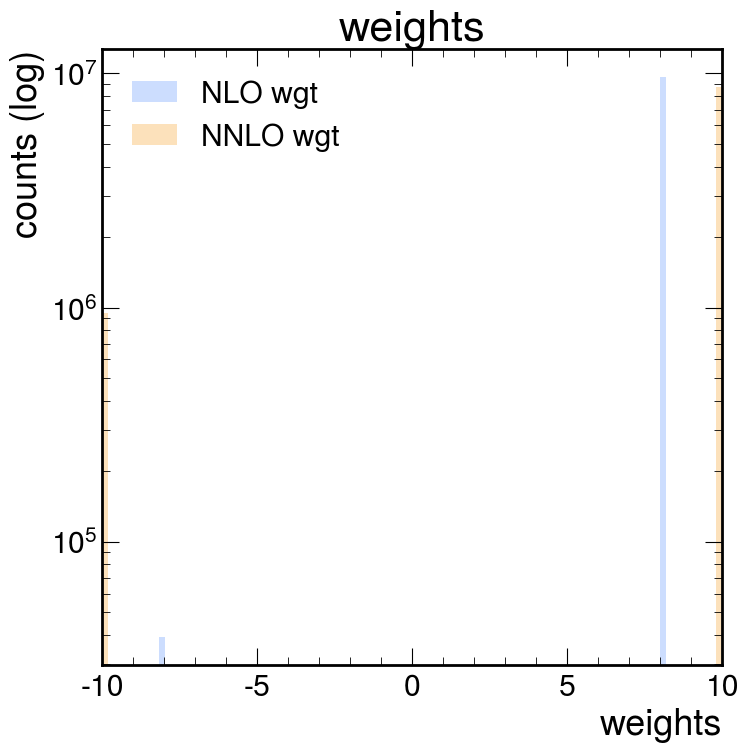

In [7]:
wgts_plot = [(X0_wgt, 'NLO wgt'), (X1_wgt, 'NNLO wgt')]

DCTR.plot_weights(wgts_plot, start = -10, stop = 10, div = 100, xscale='lin')



In [8]:
gc.collect()


23998

# prepare datasets

In [10]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_nrm = np.delete(X0_nrm, 5, -1) # E
X0_nrm = np.delete(X0_nrm, 4, -1) # eta

# garbage collection after deleting to clear memory asap
print(gc.collect())

print(X0_nrm.shape)
print(X0_nrm[0])


0
(9686913, 3, 7)
[[-0.57342503  1.03563999  0.27997945 -0.35989839  0.          1.
   0.        ]
 [ 0.28320021  0.56527613 -0.31920968  0.23710697  0.6         1.
   0.        ]
 [ 0.18415215  1.2120562   1.31850957  0.71193994 -0.6         1.
   0.        ]]


# compare datasets before reweighting

### hvq

In [ ]:
# jet multiplicity

args_multiplicity = [(X0_minPT_15_nJets[:,0], X0_wgt, 'Jet minPT 15 Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X0_minPT_30_nJets[:,0], X0_wgt, 'Jet minPT 30 Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X0_minPT_50_nJets[:,0], X0_wgt, 'Jet minPT 50 Multiplicity NLO (hvq) \n dileptonic decays')]


bins = np.linspace(-0.5, 10.5, 12)

DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


### MiNNLO

In [ ]:
# jet multiplicity

args_multiplicity = [(X1_minPT_15_nJets[:,0], X1_wgt, 'Jet minPT 15 Multiplicity NNLO (MiNNLO) \n dileptonic decays'),
                     (X1_minPT_30_nJets[:,0], X1_wgt, 'Jet minPT 30 Multiplicity NNLO (MiNNLO) \n dileptonic decays'),
                     (X1_minPT_50_nJets[:,0], X1_wgt, 'Jet minPT 50 Multiplicity NNLO (MiNNLO) \n dileptonic decays')]


bins = np.linspace(-0.5, 10.5, 12)

DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


## hvq vs MiNNLO

In [ ]:
# jet multiplicity

args_multiplicity = [(X0_minPT_15_nJets[:,0], X0_wgt, 'Jet minPT 15 Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X1_minPT_15_nJets[:,0], X1_wgt, 'Jet minPT 15 Multiplicity NNLO (MiNNLO) \n dileptonic decays')]


bins = np.linspace(-0.5, 10.5, 12)

DCTR.plot_ratio_cms_2(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


# jet multiplicity

args_multiplicity = [(X0_minPT_30_nJets[:,0], X0_wgt, 'Jet minPT 30 Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X1_minPT_30_nJets[:,0], X1_wgt, 'Jet minPT 30 Multiplicity NNLO (MiNNLO) \n dileptonic decays')]


DCTR.plot_ratio_cms_2(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


# jet multiplicity

args_multiplicity = [(X0_minPT_50_nJets[:,0], X0_wgt, 'Jet minPT 50 Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X1_minPT_50_nJets[:,0], X1_wgt, 'Jet minPT 50 Multiplicity NNLO (MiNNLO) \n dileptonic decays')]


DCTR.plot_ratio_cms_2(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')



### pT(tt)

In [ ]:
# jet cut_off should have no impact on parton pT

# hvq
args = [(X0_minPT_15, X0_wgt, 'showered NLO (hvq) Jet minPT 15 \n dileptonic decays'),
        (X0_minPT_30, X0_wgt, 'showered NLO (hvq) Jet minPT 30 \n dileptonic decays'),
        (X0_minPT_50, X0_wgt, 'showered NLO (hvq) Jet minPT 50 \n dileptonic decays')]

log_bins = np.logspace(np.log10(1), np.log10(1000), 15)


DCTR.plot_ratio_cms(args, bins = log_bins, y_scale = 'log', ratio_ylim=[0.8, 1.2])


# MiNNLO
args = [(X1_minPT_15, X1_wgt, 'showered NNLO (MiNNLO) Jet minPT 15 \n dileptonic decays'),
        (X1_minPT_30, X1_wgt, 'showered NNLO (MiNNLO) Jet minPT 30 \n dileptonic decays'),
        (X1_minPT_50, X1_wgt, 'showered NNLO (MiNNLO) Jet minPT 50 \n dileptonic decays')]

log_bins = np.logspace(np.log10(1), np.log10(1000), 15)


DCTR.plot_ratio_cms(args, bins = log_bins, y_scale = 'log', ratio_ylim=[0.8, 1.2])



# compare against old shower (HadronLevel:all = on)

In [ ]:
num_events_old = 100000
# dileptonic hvq has all 1M events in one LHE
X0_old = np.load(f'{data_dir}/POWHEG_hvq/dileptonic/converted_lhe_hvq_dileptonic.npy')[:num_events_old]

# nrm data and save to disk (only needed to run once)
'''
nrm_array_dir = f'{data_dir}/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X0_old_nrm, _ = DCTR.normalize_data(X0_old.copy(), nrm_array)
np.save(f'{data_dir}/POWHEG_hvq/dileptonic/normed_lhe_hvq_dileptonic.npy', X0_old_nrm)
'''

X0_old_nrm = np.array(np.load(f'{data_dir}/POWHEG_hvq/dileptonic/normed_lhe_hvq_dileptonic.npy')[:num_events_old])

X0_old_nJets = np.array(np.load(f'{data_dir}/POWHEG_hvq/dileptonic/jet_multiplicity_hvq_dileptonic.npy')[:num_events_old])

X0_old_wgt = X0_old_nJets[:, 1]

X0_old_jet = np.array(np.load(f'{data_dir}/POWHEG_hvq/dileptonic/jet_4vectors_hvq_dileptonic.npy')[:num_events_old])

print(X0_old.shape)
print(X0_old_nrm.shape)
print(X0_old_nJets.shape)
print(X0_old_jet.shape)


In [ ]:
# jet multiplicity
args_multiplicity = [(X0_nJets[:,0], X0_wgt, 'Jet Multiplicity NLO (hvq) NEW'),
                     (X0_old_nJets[:,0], X0_old_wgt, 'Jet Multiplicity NLO (hvq) OLD \n With HadronLevel:all = on')]


bins = np.linspace(-0.5, 12.5, 14)

DCTR.plot_ratio_cms_2(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


In [ ]:
# pT
args = [(X0, X0_wgt, 'NLO (hvq) NEW'),
        (X0_old, X0_old_wgt, 'NLO (hvq) OLD \n With HadronLevel:all = on')]



bins = np.logspace(np.log10(1), np.log10(800), 15)

DCTR.plot_ratio_cms_2(args, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3])


# DCTR reweighting


In [11]:
# calculate weights from DCTR trained on showered events
model = '../20240521_showered_new/train_20240523_regular_epochs.tf' # path to previously trained model (in .tf format (folder)) for showered events

dctr_rwgt = []
# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook



2024-08-16 18:33:16.595863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-16 18:33:16.597600: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-16 18:33:16.599617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (finn-ThinkPad-T540p): /proc/driver/nvidia/version does not exist
2024-08-16 18:33:16.643593: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


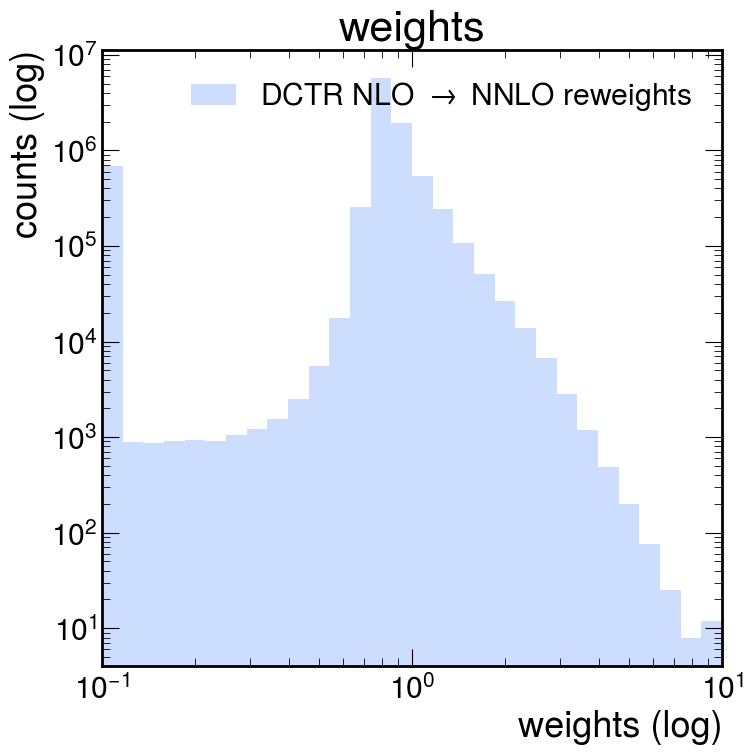

In [12]:
wgts_plot = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]

DCTR.plot_weights(wgts_plot, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
dctr_rwgt = np.multiply(dctr_rwgt[0], X0_wgt)



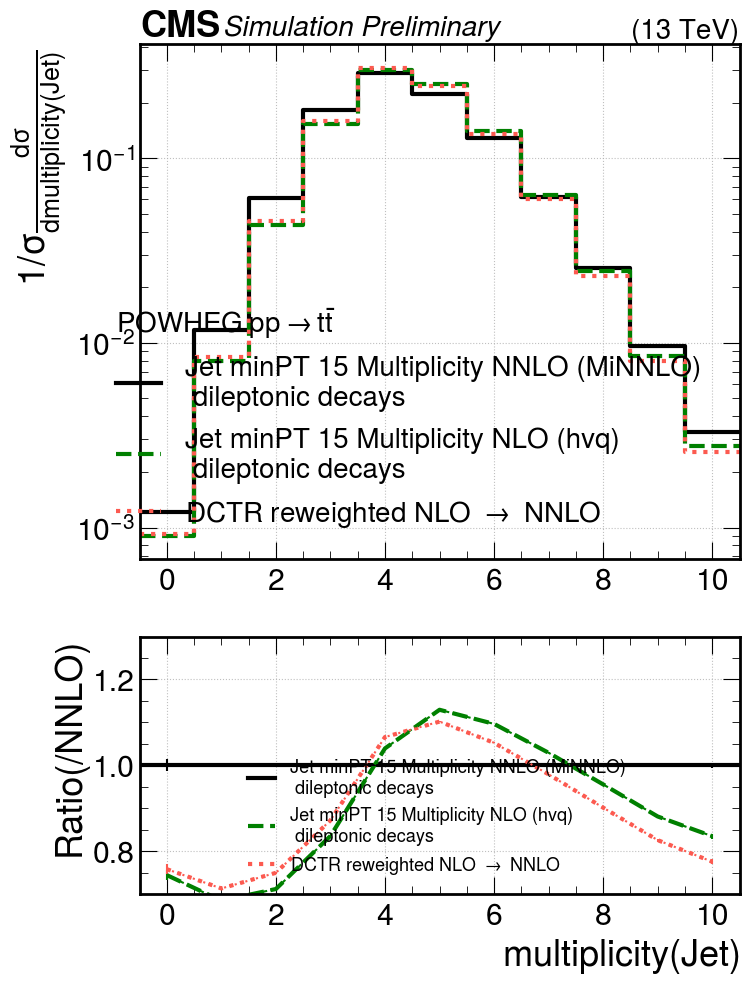

In [14]:
# jet multiplicity

args_multiplicity = [(X1_nJets[:,0], X1_wgt, 'Jet minPT 15 Multiplicity NNLO (MiNNLO) \n dileptonic decays'),
                     (X0_nJets[:,0], X0_wgt, 'Jet minPT 15 Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X0_nJets[:,0], dctr_rwgt, r'DCTR reweighted NLO $\to$ NNLO')]

bins = np.linspace(-0.5, 10.5, 12)
ratio_ylim=[0.7, 1.3]


DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=ratio_ylim, part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')



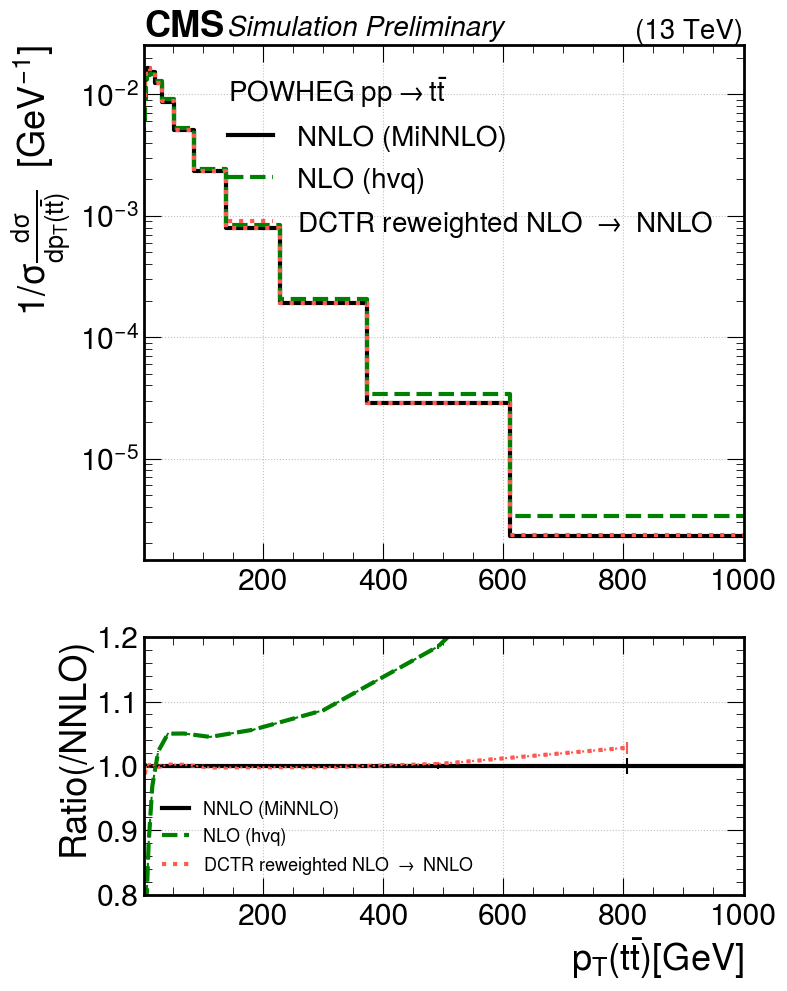

In [18]:
# pT

args = [(X1, X1_wgt, 'NNLO (MiNNLO)'),
        (X0, X0_wgt, 'NLO (hvq)'),
        (X0, dctr_rwgt, r'DCTR reweighted NLO $\to$ NNLO')]


bins = np.logspace(np.log10(1), np.log10(1000), 15)

DCTR.plot_ratio_cms(args, bins = bins, y_scale = 'log', ratio_ylim=[0.8, 1.2])


/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1393: RuntimeWarning: invalid value encountered in divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1394: RuntimeWarning: invalid value encountered in divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1395: RuntimeWarning: invalid value encountered in divide
  ratio_2 = hist2 / hist0


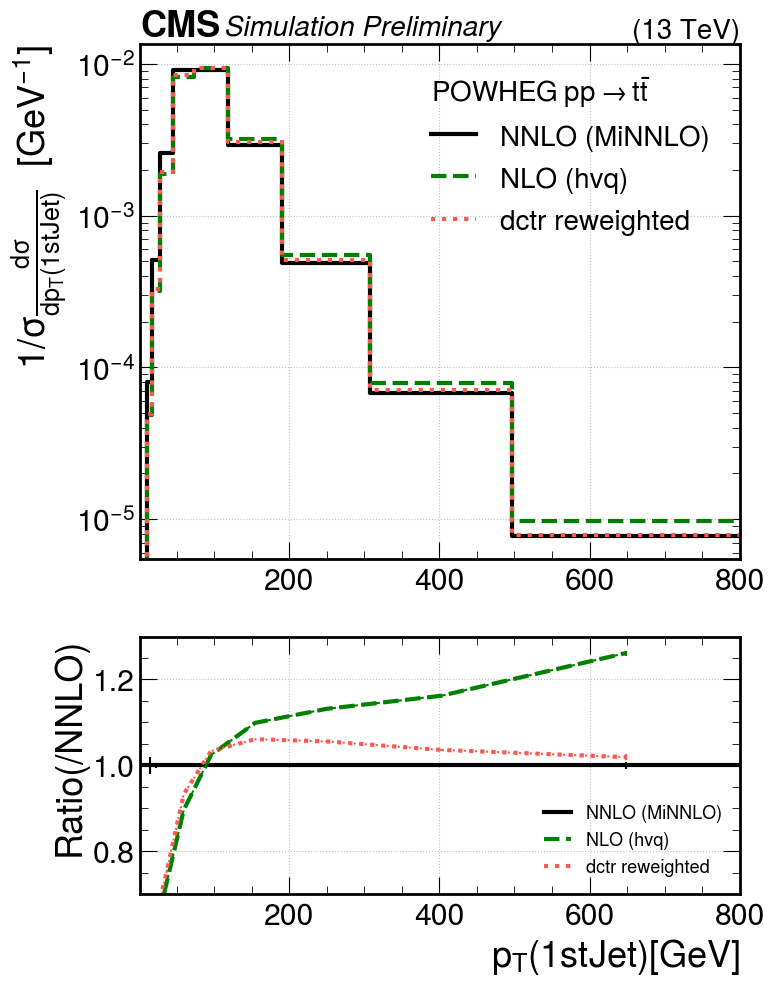

/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1393: RuntimeWarning: invalid value encountered in divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1394: RuntimeWarning: invalid value encountered in divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1395: RuntimeWarning: invalid value encountered in divide
  ratio_2 = hist2 / hist0


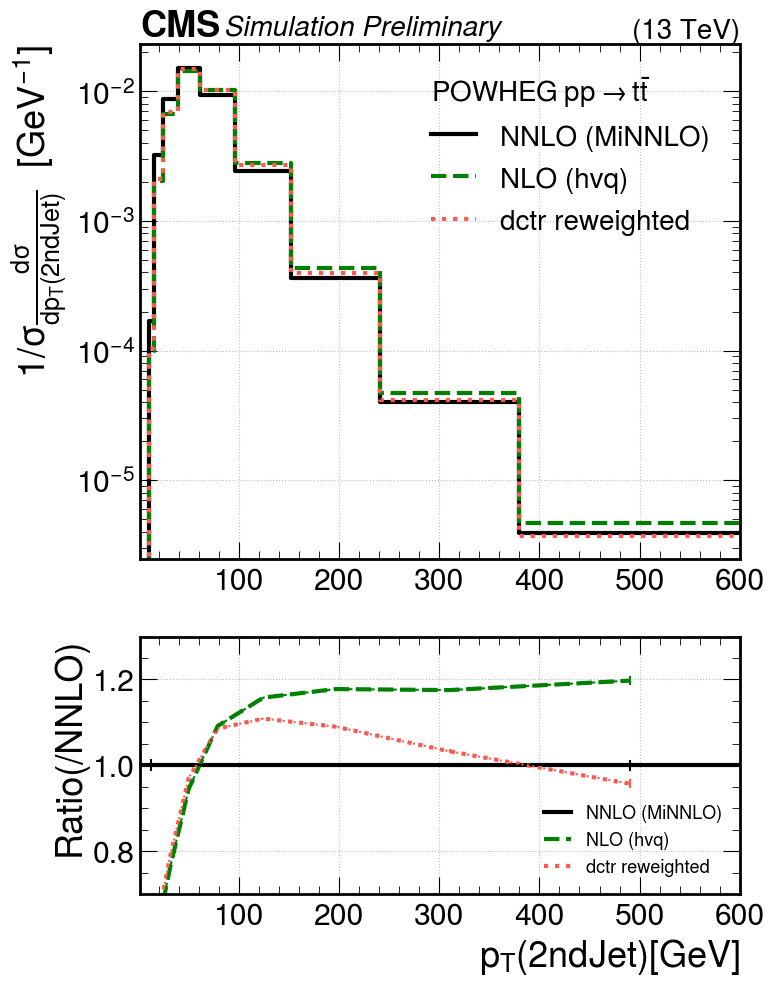

/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1393: RuntimeWarning: invalid value encountered in divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1394: RuntimeWarning: invalid value encountered in divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1395: RuntimeWarning: invalid value encountered in divide
  ratio_2 = hist2 / hist0


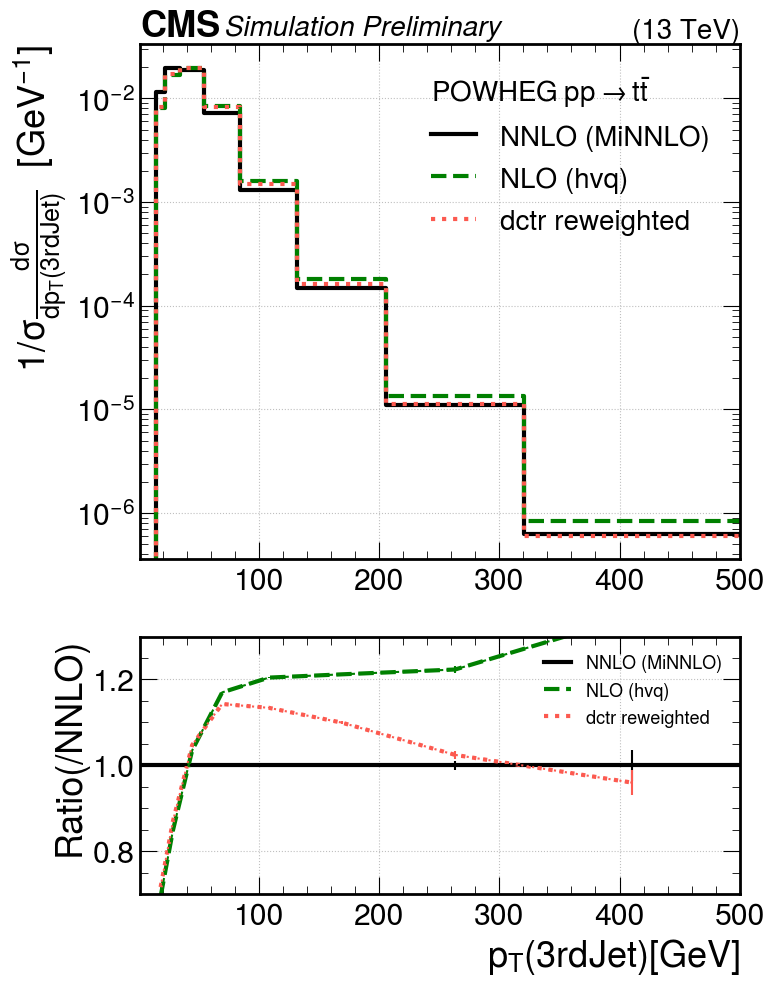

In [20]:
# jet pT

log_bins = np.logspace(np.log10(1), np.log10(800), 15)

args_jet_0 = [(X1_jet[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 0, 0], dctr_rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_0, bins = log_bins, y_scale = 'log', part_label='1st Jet', ratio_ylim=(0.7, 1.3))

log_bins = np.logspace(np.log10(1), np.log10(600), 15)
args_jet_1 = [(X1_jet[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 1, 0], dctr_rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_1, bins = log_bins, y_scale = 'log', part_label='2nd Jet', ratio_ylim=(0.7, 1.3))

log_bins = np.logspace(np.log10(1), np.log10(500), 15)
args_jet_2 = [(X1_jet[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 2, 0], dctr_rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_2, bins = log_bins, y_scale = 'log', part_label='3rd Jet', ratio_ylim=(0.7, 1.3))




/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1393: RuntimeWarning: invalid value encountered in divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1394: RuntimeWarning: invalid value encountered in divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240712_jets_newer/../DCTR.py:1395: RuntimeWarning: invalid value encountered in divide
  ratio_2 = hist2 / hist0


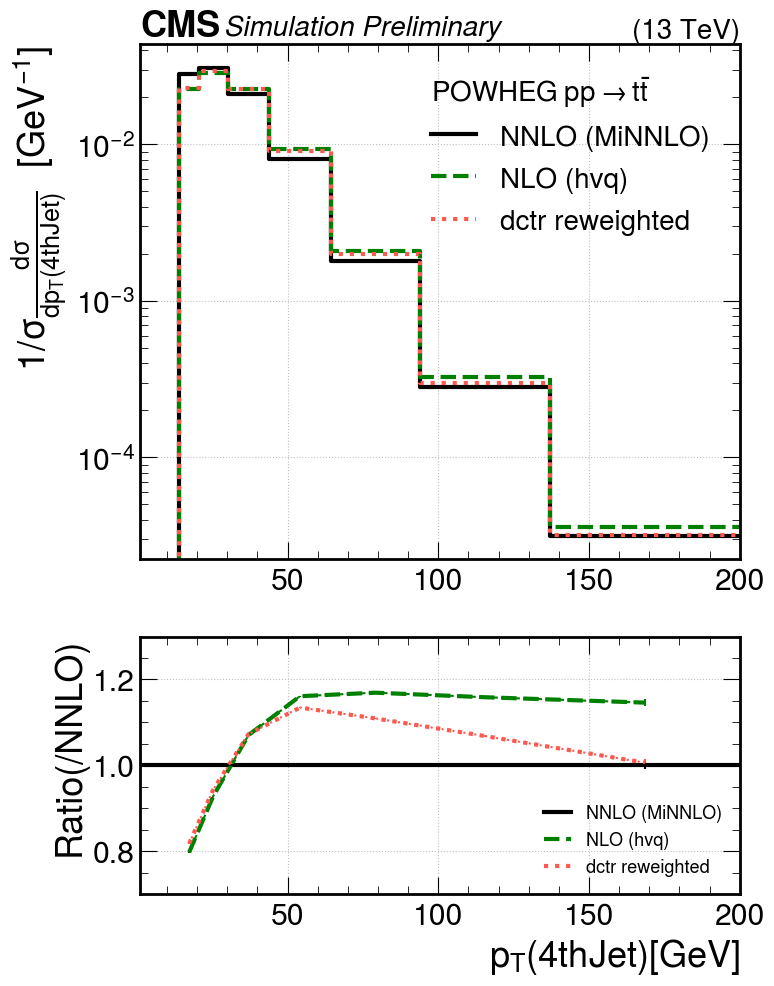

In [21]:
log_bins = np.logspace(np.log10(1), np.log10(200), 15)
args_jet_3 = [(X1_jet[:, 3, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 3, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 3, 0], dctr_rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_3, bins = log_bins, y_scale = 'log', part_label='4th Jet', ratio_ylim=(0.7, 1.3))


np.shape(X0_jet_pt_sums) = (9686913,)
np.shape(X1_jet_pt_sums) = (9686913,)


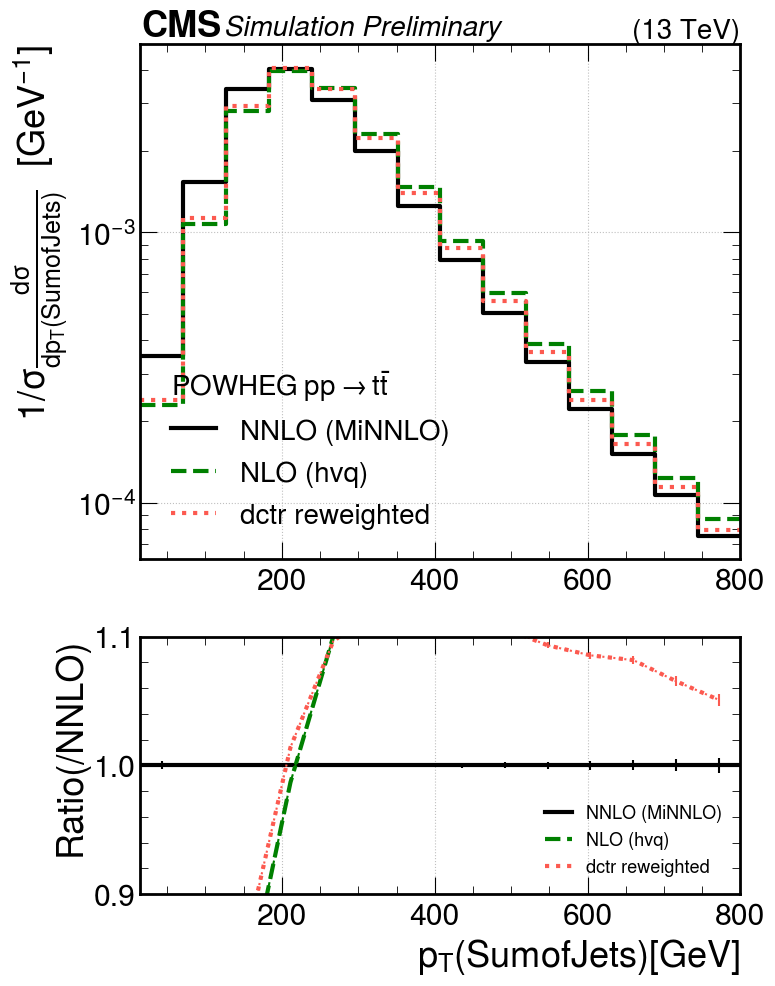

In [22]:
# sum of jet pt per event

X0_jet_pt_sums = []
for event in X0_jet:
    X0_jet_pt_sums.append(np.sum(event[:,0]))

X1_jet_pt_sums = []
for event in X1_jet:
    X1_jet_pt_sums.append(np.sum(event[:,0]))

    
print(f'{np.shape(X0_jet_pt_sums) = }')
print(f'{np.shape(X1_jet_pt_sums) = }')
log_bins = np.logspace(np.log10(30), np.log10(1000), 15)

args_jet_sum = [(np.array(X1_jet_pt_sums), X1_wgt, 'NNLO (MiNNLO)'),
                (np.array(X0_jet_pt_sums), X0_wgt, 'NLO (hvq)'),
                (np.array(X0_jet_pt_sums), dctr_rwgt, 'dctr reweighted')]

#log_bins = np.logspace(np.log10(30), np.log10(1000), 15)
lin_bins = np.linspace(15, 800, 15)

DCTR.plot_ratio_cms(args_jet_sum, bins = lin_bins, y_scale = 'log', part_label='Sum of Jets', ratio_ylim=(0.9, 1.1))




### compare to old events


In [ ]:
# reduce stats to compare to previous 

num_events = int(1e6)

X0       = np.array(X0[:num_events])
X0_wgt   = np.array(X0_wgt[:num_events])
X0_nrm   = np.array(X0_nrm[:num_events])
X0_nJets = np.array(X0_nJets[:num_events])
X0_jet   = np.array(X0_jet[:num_events])


print(X0.shape)
print(X0_wgt.shape)
print(X0_nrm.shape)
print(X0_nJets.shape)
print(X0_jet.shape)


# reduce stats to compare to previous 

num_events = int(1e6)

X1       = np.array(X1[:num_events])
X1_wgt   = np.array(X1_wgt[:num_events])
X1_nrm   = np.array(X1_nrm[:num_events])
X1_nJets = np.array(X1_nJets[:num_events])
X1_jet   = np.array(X1_jet[:num_events])


print(X1.shape)
print(X1_wgt.shape)
print(X1_nrm.shape)
print(X1_nJets.shape)
print(X1_jet.shape)



In [ ]:
# calculate weights from DCTR trained on showered events
model = '../20240521_showered_new/train_20240523_regular_epochs.tf' # path to previously trained model (in .tf format (folder)) for showered events

dctr_rwgt = []
# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook



In [ ]:
X0_wgt = X0_wgt[:num_events]
X1_wgt = X1_wgt[:num_events]

wgts_plot = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]

DCTR.plot_weights(wgts_plot, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
dctr_rwgt = np.multiply(dctr_rwgt[0], X0_wgt)



In [ ]:
# jet multiplicity

args_multiplicity = [(X1_nJets[:,0], X1_wgt, 'Jet minPT 15 Multiplicity NNLO (MiNNLO) \n dileptonic decays'),
                     (X0_nJets[:,0], X0_wgt, 'Jet minPT 15 Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X0_nJets[:,0], dctr_rwgt, r'DCTR reweighted NLO $\to$ NNLO')]

bins = np.linspace(-0.5, 10.5, 12)
ratio_ylim=[0.7, 1.3]


DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=ratio_ylim, part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')



In [ ]:
# pT

args = [(X1, X1_wgt, 'NNLO (MiNNLO)'),
        (X0, X0_wgt, 'NLO (hvq)'),
        (X0, dctr_rwgt, r'DCTR reweighted NLO $\to$ NNLO')]


bins = np.logspace(np.log10(30), np.log10(800), 15)

DCTR.plot_ratio_cms(args, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3])


In [ ]:
# jet pT

log_bins = np.logspace(np.log10(30), np.log10(800), 15)

args_jet_0 = [(X1_jet[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 0, 0], dctr_rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_0, bins = log_bins, y_scale = 'log', part_label='1st Jet', ratio_ylim=(0.7, 1.3))

log_bins = np.logspace(np.log10(30), np.log10(600), 15)
args_jet_1 = [(X1_jet[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 1, 0], dctr_rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_1, bins = log_bins, y_scale = 'log', part_label='2nd Jet', ratio_ylim=(0.7, 1.3))

log_bins = np.logspace(np.log10(30), np.log10(500), 15)
args_jet_2 = [(X1_jet[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 2, 0], dctr_rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_2, bins = log_bins, y_scale = 'log', part_label='3rd Jet', ratio_ylim=(0.7, 1.3))



In [ ]:
log_bins = np.logspace(np.log10(30), np.log10(200), 15)
args_jet_3 = [(X1_jet[:, 3, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 3, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 3, 0], dctr_rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_3, bins = log_bins, y_scale = 'log', part_label='4th Jet', ratio_ylim=(0.7, 1.3))


In [ ]:
# sum of jet pt per event

X0_jet_pt_sums = []
for event in X0_jet:
    X0_jet_pt_sums.append(np.sum(event[:,0]))

X1_jet_pt_sums = []
for event in X1_jet:
    X1_jet_pt_sums.append(np.sum(event[:,0]))

    
print(f'{np.shape(X0_jet_pt_sums) = }')
print(f'{np.shape(X1_jet_pt_sums) = }')
log_bins = np.logspace(np.log10(30), np.log10(1000), 15)

args_jet_sum = [(np.array(X1_jet_pt_sums), X1_wgt, 'NNLO (MiNNLO)'),
                (np.array(X0_jet_pt_sums), X0_wgt, 'NLO (hvq)'),
                (np.array(X0_jet_pt_sums), dctr_rwgt, 'dctr reweighted')]

#log_bins = np.logspace(np.log10(30), np.log10(1000), 15)
lin_bins = np.linspace(15, 800, 15)

DCTR.plot_ratio_cms(args_jet_sum, bins = lin_bins, y_scale = 'log', part_label='Sum of Jets', ratio_ylim=(0.9, 1.1))




In [ ]:
X0_wgt = X0_nJets[:,1]
X1_wgt = X0_nJets[:,1]


In [ ]:
# dileptonic hvq has all 1M events in one LHE

X0_minPT_15 = np.load(f'{data_dir}/POWHEG_hvq/dileptonic/converted_lhe_hvq_dileptonic_minPT_15_ProcessAll.npy')[:num_events]

# nrm data and save to disk (only needed to run once)
'''
nrm_array_dir = f'{data_dir}/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X0_minPT_15_nrm, _ = DCTR.normalize_data(X0_minPT_15.copy(), nrm_array)
np.save(f'{data_dir}/POWHEG_hvq/dileptonic/normed_lhe_hvq_dileptonic_minPT_15_ProcessAll.npy', X0_minPT_15_nrm)
'''

X0_minPT_15_nrm = np.array(np.load(f'{data_dir}/POWHEG_hvq/dileptonic/normed_lhe_hvq_dileptonic_minPT_15_ProcessAll.npy')[:num_events])

X0_minPT_15_nJets = np.array(np.load(f'{data_dir}/POWHEG_hvq/dileptonic/jet_multiplicity_hvq_dileptonic_minPT_15_ProcessAll.npy')[:num_events])
X0_wgt_minPT_15 = X0_minPT_15_nJets[:,1] # should be the same for all minPT levels, since they are based on the same events | verified below

X0_minPT_15_jet = np.array(np.load(f'{data_dir}/POWHEG_hvq/dileptonic/jet_4vectors_hvq_dileptonic_minPT_15_ProcessAll.npy')[:num_events])

print(X0_minPT_15.shape)
print(X0_minPT_15_nrm.shape)
print(X0_minPT_15_nJets.shape)
print(X0_minPT_15_jet.shape)




In [ ]:
# pT

args = [(X0, X0_wgt, 'NLO NEW'),
        (X0_minPT_15, X0_wgt_minPT_15, 'NLO OLD')]


bins = np.logspace(np.log10(30), np.log10(800), 15)

DCTR.plot_ratio_cms_2(args, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3])



In [ ]:
# MiNNLO | only 10k events per lhe

X1_minPT_15 = []
X1_minPT_15_nJets = []
X1_minPT_15_jet = []

for i in range(1, 101):
    X1_minPT_15.extend(np.load(f'{data_dir}/MiNNLO/showered/minPT_15/converted_lhe_MiNNLO_{i}_minPT_15_ProcessAll.npy'))
    X1_minPT_15_nJets.extend(np.load(f'{data_dir}/MiNNLO/showered/minPT_15/jet_multiplicity_MiNNLO_{i}_minPT_15_ProcessAll.npy'))
    X1_minPT_15_jet.extend(np.load(f'{data_dir}/MiNNLO/showered/minPT_15/jet_4vectors_MiNNLO_{i}_minPT_15_ProcessAll.npy'))

X1_minPT_15 = np.array(X1_minPT_15[:num_events])

# nrm data and save to disk (only needed to run once)
'''
nrm_array_dir = f'{data_dir}/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X1_minPT_15_nrm, _ = DCTR.normalize_data(X1_minPT_15.copy(), nrm_array)
np.save(f'{data_dir}/MiNNLO/showered/minPT_15/normed_lhe_MiNNLO_minPT_15_ProcessAll.npy', X1_minPT_15_nrm)
'''

X1_minPT_15_nrm = np.array(np.load(f'{data_dir}/MiNNLO/showered/minPT_15/normed_lhe_MiNNLO_minPT_15_ProcessAll.npy')[:num_events])

X1_minPT_15_nJets = np.array(X1_minPT_15_nJets[:num_events])
X1_minPT_15_jet = np.array(X1_minPT_15_jet[:num_events])

X1_wgt_minPT_15 = X1_minPT_15_nJets[:, 1] # should be the same for all minPT levels, since they are based on the same events | verified below

print(X1_minPT_15.shape)
print(X1_minPT_15_nrm.shape)
print(X1_minPT_15_nJets.shape)
print(X1_minPT_15_jet.shape)



In [ ]:
print(len(X1_wgt))

In [ ]:
# pT

args = [(X1, X1_wgt, 'NNLO NEW'),
        (X1_minPT_15, X1_wgt_minPT_15, 'NNLO OLD')]


bins = np.logspace(np.log10(30), np.log10(800), 15)

DCTR.plot_ratio_cms_2(args, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3])

